In [1]:
import os
import sys
import time
import random
import numpy as np
from tqdm import tqdm
import torch
from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

from density_decoding.utils.utils import set_seed, to_device
from density_decoding.utils.data_utils import (
    IBLDataLoader,
    initilize_gaussian_mixtures,
    initialize_weight_matrix
)
from density_decoding.models.glm import train_glm
from density_decoding.models.advi import (
    ModelDataLoader, 
    ADVI,
    train_advi,
    compute_posterior_weight_matrix
)
from density_decoding.decoders.behavior_decoder import generic_decoder, sliding_window_decoder

seed = 666
set_seed(seed)

device = torch.device("cpu")

In [2]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 12.5
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

#### continuous behaviors

In [3]:
pid = "523f8301-4f56-4faf-ab33-a9ff11331118"

ibl_data_loader = IBLDataLoader(
    pid, 
    trial_length = 1.5, 
    n_t_bins = 30
)

pulling data from ibl database ..
eid: 88224abb-5746-431f-9c17-17d7ef806e6a
pid: 523f8301-4f56-4faf-ab33-a9ff11331118
number of trials found: 300 (active: 300)
prior for this session is not found.
found 300 trials from 37.78 to 2123.22 sec.


In [4]:
wheel_speed = ibl_data_loader.process_behaviors("wheel_speed")
wheel_speed = normalize(wheel_speed)

In [5]:
dir_path = Path(f"/mnt/3TB/data/rs_locs_residdec/pid{pid}")
spike_index = np.load(dir_path / "spike_index.npy")
spike_features = np.load(dir_path / "localization_results.npy")
spike_times, spike_channels = spike_index.T

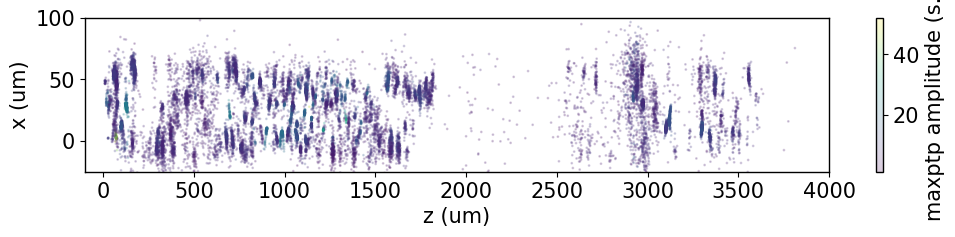

In [6]:
n_spikes_display = 2_0000
x, z, maxptp = spike_features[:n_spikes_display].T

fig, ax = plt.subplots(1, 1, figsize=(12,2))
im = ax.scatter(z, x, c=maxptp, s=1, alpha=.2)
cbar = plt.colorbar(im, ax=ax)
ax.set_xlim(-100, 4000)
ax.set_ylim(-25, 100)
ax.set_xlabel("z (um)")
ax.set_ylabel("x (um)")
cbar.set_label("maxptp amplitude (s.u.)")
plt.show()

In [7]:
brain_region = "po"

In [8]:
bin_spike_features, bin_trial_idxs, bin_time_idxs = \
    ibl_data_loader.load_spike_features(
        spike_times, spike_channels, spike_features, brain_region
    )
thresholded_spike_count = ibl_data_loader.load_thresholded_units(
    spike_times, spike_channels, brain_region
)
all_sorted_spike_count = ibl_data_loader.load_all_sorted_units(brain_region)
good_sorted_spike_count = ibl_data_loader.load_good_sorted_units(brain_region)

found 120 channels in region po


Process spike features: 100%|█████████████████| 300/300 [00:09<00:00, 32.58it/s]


found 120 channels in region po


Compute spike count: 100%|███████████████████| 300/300 [00:00<00:00, 846.67it/s]


found 301 Kilosort units in region po


Compute spike count: 100%|███████████████████| 300/300 [00:00<00:00, 541.17it/s]


found 73 good units in region po


Compute spike count: 100%|██████████████████| 300/300 [00:00<00:00, 1499.18it/s]


In [9]:
trial_idxs = np.arange(ibl_data_loader.n_trials)
random.shuffle(trial_idxs)
train, test = train_test_split(trial_idxs, test_size=0.2)

In [10]:
spike_features = np.concatenate(
    np.concatenate(bin_spike_features)
)
gmm = initilize_gaussian_mixtures(
    spike_features=spike_features[:,1:], 
    spike_channels=spike_features[:,0], 
    method="isosplit", 
    verbose=False,
)
n_t = ibl_data_loader.n_t_bins
n_c = gmm.means_.shape[0]
n_d = gmm.means_.shape[1]
print(f"Initialized a mixture with {n_c} components.")

init_weight_matrix = initialize_weight_matrix(
    gmm,
    bin_spike_features, 
)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Initialize GMM: 100%|█████████████████████████| 120/120 [00:06<00:00, 18.52it/s]


Initialized a mixture with 201 components.


Initialize weight matrix: 100%|███████████████| 300/300 [00:27<00:00, 10.82it/s]


In [11]:
model_data_loader = ModelDataLoader(
    bin_spike_features,
    wheel_speed,
    bin_trial_idxs,
    bin_time_idxs
)

train_spike_features, train_trial_idxs, train_time_idxs, \
    test_spike_features, test_trial_idxs, test_time_idxs = \
        model_data_loader.split_train_test(train, test)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [12]:
glm, losses = train_glm(
    X = init_weight_matrix, 
    Y = wheel_speed, 
    train = train,
    test = test,
    learning_rate = 1e-3,
    n_epochs = 5000
)

Train GLM:: 100%|███████████████████████████| 5000/5000 [00:58<00:00, 85.44it/s]


In [13]:
batch_size = 32
batch_idxs = list(zip(*(iter(train),) * batch_size))

advi = ADVI(
    n_r = 2,
    n_t = n_t, 
    gmm = gmm, 
    U_prior = glm.U.detach(),
    V_prior = glm.V.detach(),
    b_prior = glm.b.detach(),
    device = device
)

elbos = train_advi(
    advi,
    spike_features = to_device(train_spike_features[:,1:], device), 
    behaviors = to_device(model_data_loader.bin_behaviors, device), 
    trial_idxs = to_device(train_trial_idxs, device), 
    time_idxs = to_device(train_time_idxs, device), 
    batch_idxs= batch_idxs, 
    optim = torch.optim.Adam(advi.parameters(), lr=1e-3, weight_decay=1e-3),
    max_iter=5000,
)

Train ADVI: 100%|███████████████████████████| 5000/5000 [11:46<00:00,  7.08it/s]


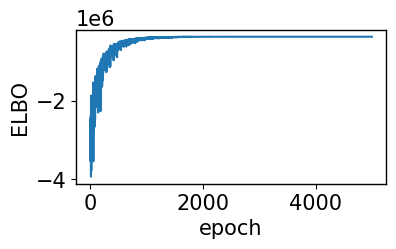

In [14]:
plt.figure(figsize=(4,2))
plt.plot(elbos)
plt.xlabel("epoch")
plt.ylabel("ELBO");

In [15]:
y_train, y_test, y_pred, _ = generic_decoder(
    thresholded_spike_count, wheel_speed, train, test, 
    behavior_type="continuous", penalty_strength=1e3, seed=seed
)

post_params = {
    "b": advi.b.loc.detach().numpy(),
    "U": advi.U.loc.detach().numpy(),
    "V": advi.V.loc.detach().numpy(),
    "beta": advi.U.loc.detach().numpy() @ advi.V.loc.detach().numpy(),
    "means": advi.means.detach().numpy(),
    "covs": advi.covs.detach().numpy(),
}

mixture_weights, weight_matrix, firing_rates = compute_posterior_weight_matrix(
    bin_spike_features, y_train, y_pred, train, test, post_params, n_workers=1
)

Compute weight matrix: 100%|██████████████████| 300/300 [00:35<00:00,  8.39it/s]


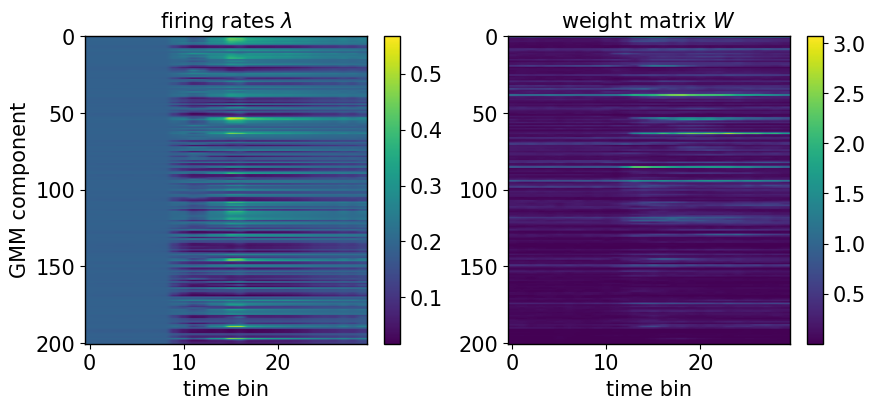

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
im1 = ax1.imshow(firing_rates.mean(0), aspect="auto")
im2 = ax2.imshow(weight_matrix.mean(0), aspect="auto")
cbar = plt.colorbar(im1, ax=ax1)
cbar = plt.colorbar(im2, ax=ax2)
ax1.set_xlabel("time bin")
ax2.set_xlabel("time bin")
ax1.set_ylabel("GMM component")
ax1.set_title(r"firing rates $\lambda$")
ax2.set_title(r"weight matrix $W$");

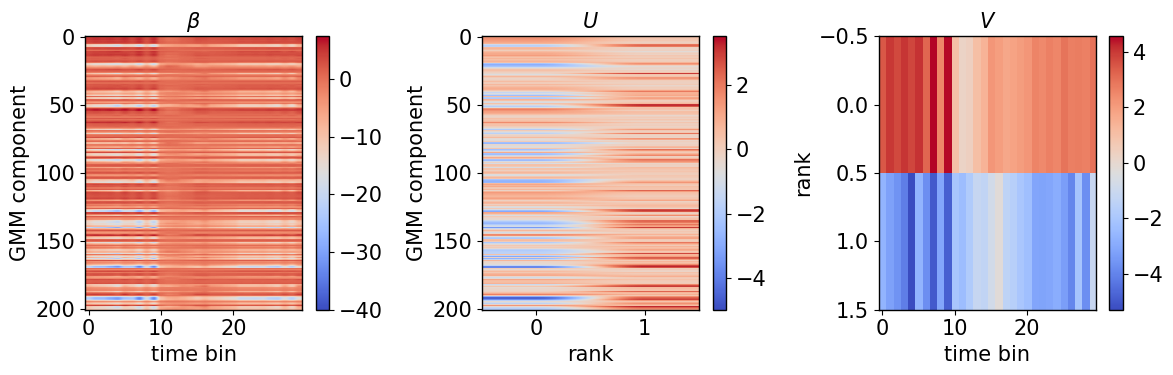

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
im1 = ax1.imshow(post_params["beta"], aspect="auto", cmap="coolwarm")
im2 = ax2.imshow(post_params["U"], aspect="auto", cmap="coolwarm")
im3 = ax3.imshow(post_params["V"], aspect="auto", cmap="coolwarm")
cbar = plt.colorbar(im1, ax=ax1)
cbar = plt.colorbar(im2, ax=ax2)
cbar = plt.colorbar(im3, ax=ax3)
ax1.set_xlabel("time bin")
ax2.set_xlabel("rank")
ax3.set_xlabel("time bin")
ax1.set_ylabel("GMM component")
ax2.set_ylabel("GMM component")
ax3.set_ylabel("rank")
ax1.set_title(r"$\beta$")
ax2.set_title(r"$U$")
ax3.set_title(r"$V$")
plt.tight_layout()

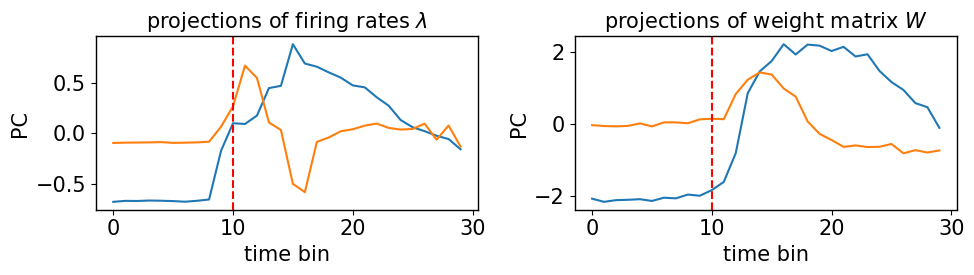

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
pca = PCA(n_components=2)
pca.fit(firing_rates.mean(0).T)
fr_proj = pca.transform(firing_rates.mean(0).T)
ax1.plot(fr_proj)
ax1.axvline(x=10, c="r", linestyle="--")
ax1.set_xlabel("time bin")
ax1.set_ylabel("PC")
ax1.set_title(r"projections of firing rates $\lambda$")

pca.fit(weight_matrix.mean(0).T)
w_proj = pca.transform(weight_matrix.mean(0).T)
ax2.plot(w_proj)
ax2.axvline(x=10, c="r", linestyle="--")
ax2.set_xlabel("time bin")
ax2.set_ylabel("PC")
ax2.set_title(r"projections of weight matrix $W$")

plt.tight_layout()

In [19]:
_, y_test, density_pred, metrics = sliding_window_decoder(
    weight_matrix, wheel_speed, train, test, behavior_type="continuous"
)

R2: 0.448, MSE: 0.012, Corr: 0.669


In [20]:
_, y_test, ks_pred, metrics = sliding_window_decoder(
    all_sorted_spike_count, wheel_speed, train, test, behavior_type="continuous"
)

R2: 0.427, MSE: 0.012, Corr: 0.654


In [21]:
_, _, _, _ = sliding_window_decoder(
    good_sorted_spike_count, wheel_speed, train, test, behavior_type="continuous"
)

R2: 0.372, MSE: 0.013, Corr: 0.610


In [22]:
_, _, _, _ = sliding_window_decoder(
    thresholded_spike_count, wheel_speed, train, test, behavior_type="continuous"
)

R2: 0.371, MSE: 0.013, Corr: 0.609


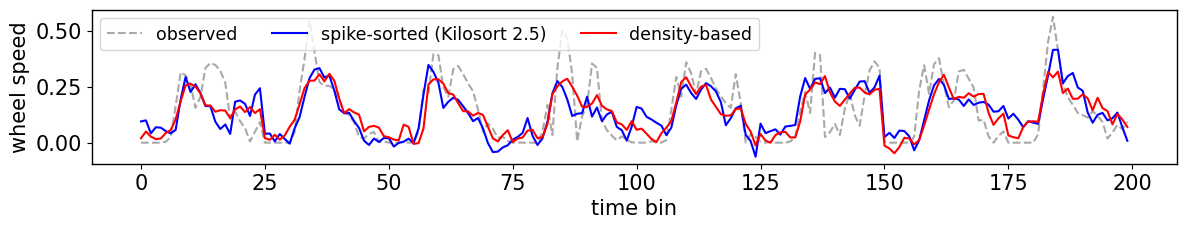

In [23]:
plt.figure(figsize=(14,2))
plt.plot(y_test[:200], c="darkgray", linestyle="--", label="observed")
plt.plot(ks_pred[:200], c="blue", linestyle="-", label="spike-sorted (Kilosort 2.5)")
plt.plot(density_pred[:200], c="red", linestyle="-", label="density-based")
plt.xlabel("time bin")
plt.ylabel("wheel speed")
plt.legend(ncol=3, loc="upper left")
plt.show()

#### binary choice

In [24]:
ibl_data_loader = IBLDataLoader(
    pid, 
    trial_length = 1.5, 
    n_t_bins = 15 # large T may cause over-fitting (too many params to learn)
)

pulling data from ibl database ..
eid: 88224abb-5746-431f-9c17-17d7ef806e6a
pid: 523f8301-4f56-4faf-ab33-a9ff11331118
number of trials found: 300 (active: 300)
prior for this session is not found.
found 300 trials from 37.78 to 2123.22 sec.


In [25]:
dir_path = Path(f"/mnt/3TB/data/rs_locs_residdec/pid{pid}")
spike_index = np.load(dir_path / "spike_index.npy")
spike_features = np.load(dir_path / "localization_results.npy")
spike_times, spike_channels = spike_index.T

In [26]:
brain_region = "po"
bin_spike_features, bin_trial_idxs, bin_time_idxs = \
    ibl_data_loader.load_spike_features(
        spike_times, spike_channels, spike_features, brain_region
    )
thresholded_spike_count = ibl_data_loader.load_thresholded_units(
    spike_times, spike_channels, brain_region
)
all_sorted_spike_count = ibl_data_loader.load_all_sorted_units(brain_region)
good_sorted_spike_count = ibl_data_loader.load_good_sorted_units(brain_region)

found 120 channels in region po


Process spike features: 100%|█████████████████| 300/300 [00:08<00:00, 35.69it/s]


found 120 channels in region po


Compute spike count: 100%|███████████████████| 300/300 [00:00<00:00, 876.29it/s]


found 301 Kilosort units in region po


Compute spike count: 100%|███████████████████| 300/300 [00:00<00:00, 580.43it/s]


found 73 good units in region po


Compute spike count: 100%|██████████████████| 300/300 [00:00<00:00, 1543.91it/s]


In [27]:
spike_features = np.concatenate(
    np.concatenate(bin_spike_features)
)
gmm = initilize_gaussian_mixtures(
    spike_features=spike_features[:,1:], 
    spike_channels=spike_features[:,0], 
    method="isosplit", 
    verbose=False,
)
n_t = ibl_data_loader.n_t_bins
n_c = gmm.means_.shape[0]
n_d = gmm.means_.shape[1]
print(f"Initialized a mixture with {n_c} components.")

init_weight_matrix = initialize_weight_matrix(
    gmm,
    bin_spike_features, 
)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Initialize GMM: 100%|█████████████████████████| 120/120 [00:06<00:00, 17.96it/s]


Initialized a mixture with 201 components.


Initialize weight matrix: 100%|███████████████| 300/300 [00:17<00:00, 17.22it/s]


In [28]:
choice = ibl_data_loader.process_behaviors("choice").reshape(-1,1)

In [29]:
skf = StratifiedKFold(n_splits=5)
train, test = list(skf.split(init_weight_matrix, choice))[0]

In [30]:
model_data_loader = ModelDataLoader(
    bin_spike_features,
    choice,
    bin_trial_idxs,
    bin_time_idxs
)

train_spike_features, train_trial_idxs, train_time_idxs, \
    test_spike_features, test_trial_idxs, test_time_idxs = \
        model_data_loader.split_train_test(train, test)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [31]:
glm, losses = train_glm(
    X = init_weight_matrix, 
    Y = choice, 
    train = train,
    test = test,
    learning_rate=1e-3,
    n_epochs=5000
)

Train GLM:: 100%|██████████████████████████| 5000/5000 [00:26<00:00, 191.23it/s]


In [32]:
batch_size = 32
batch_idxs = list(zip(*(iter(train),) * batch_size))

advi = ADVI(
    n_r = 2,
    n_t = n_t, 
    gmm = gmm, 
    U_prior = glm.U.detach(),
    V_prior = glm.V.detach(),
    b_prior = glm.b.detach(),
    device = device
)

elbos = train_advi(
    advi,
    spike_features = to_device(train_spike_features[:,1:], device), 
    behaviors = to_device(model_data_loader.bin_behaviors, device), 
    trial_idxs = to_device(train_trial_idxs, device), 
    time_idxs = to_device(train_time_idxs, device), 
    batch_idxs= batch_idxs, 
    optim = torch.optim.Adam(advi.parameters(), lr=1e-3, weight_decay=1e-3),
    max_iter=5000,
)

Train ADVI: 100%|███████████████████████████| 5000/5000 [07:33<00:00, 11.03it/s]


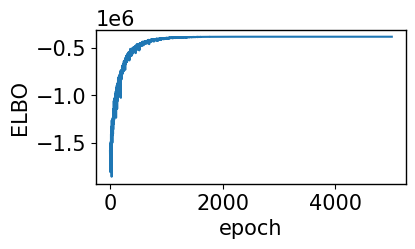

In [33]:
plt.figure(figsize=(4,2))
plt.plot(elbos)
plt.xlabel("epoch")
plt.ylabel("ELBO");

In [34]:
y_train, y_test, y_pred, y_prob, _ = generic_decoder(
    thresholded_spike_count, choice.squeeze(), train, test, 
    behavior_type="discrete", seed=seed, return_prob=True
)

post_params = {
    "b": advi.b.loc.detach().numpy(),
    "U": advi.U.loc.detach().numpy(),
    "V": advi.V.loc.detach().numpy(),
    "beta": advi.U.loc.detach().numpy() @ advi.V.loc.detach().numpy(),
    "means": advi.means.detach().numpy(),
    "covs": advi.covs.detach().numpy(),
}

mixture_weights, weight_matrix, firing_rates = compute_posterior_weight_matrix(
    bin_spike_features, y_train, y_test, train, test, post_params, n_workers=1
)

Compute weight matrix: 100%|██████████████████| 300/300 [00:21<00:00, 13.82it/s]


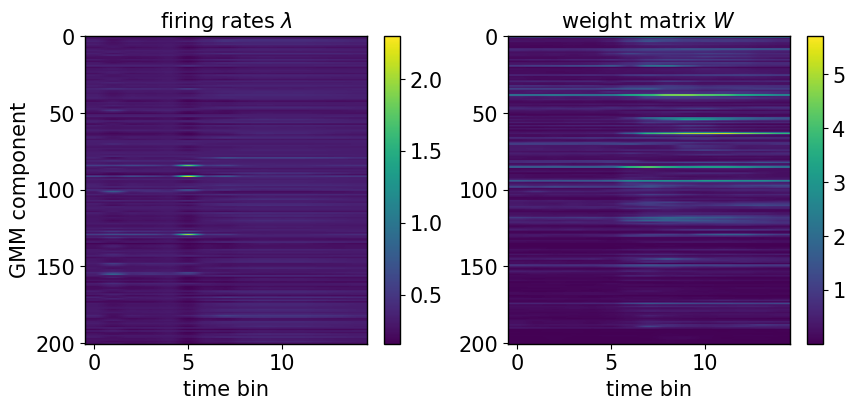

In [35]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
im1 = ax1.imshow(firing_rates.mean(0), aspect="auto")
im2 = ax2.imshow(weight_matrix.mean(0), aspect="auto")
cbar = plt.colorbar(im1, ax=ax1)
cbar = plt.colorbar(im2, ax=ax2)
ax1.set_xlabel("time bin")
ax2.set_xlabel("time bin")
ax1.set_ylabel("GMM component")
ax1.set_title(r"firing rates $\lambda$")
ax2.set_title(r"weight matrix $W$");

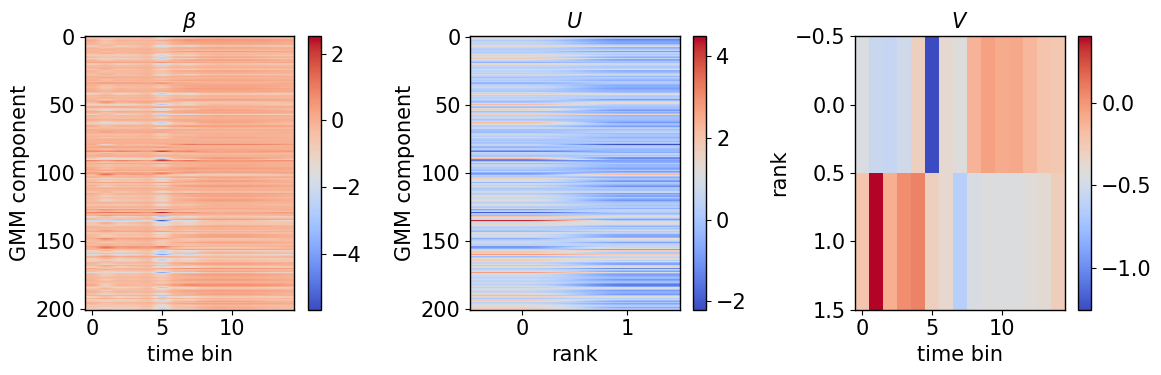

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))
im1 = ax1.imshow(post_params["beta"], aspect="auto", cmap="coolwarm")
im2 = ax2.imshow(post_params["U"], aspect="auto", cmap="coolwarm")
im3 = ax3.imshow(post_params["V"], aspect="auto", cmap="coolwarm")
cbar = plt.colorbar(im1, ax=ax1)
cbar = plt.colorbar(im2, ax=ax2)
cbar = plt.colorbar(im3, ax=ax3)
ax1.set_xlabel("time bin")
ax2.set_xlabel("rank")
ax3.set_xlabel("time bin")
ax1.set_ylabel("GMM component")
ax2.set_ylabel("GMM component")
ax3.set_ylabel("rank")
ax1.set_title(r"$\beta$")
ax2.set_title(r"$U$")
ax3.set_title(r"$V$")
plt.tight_layout()

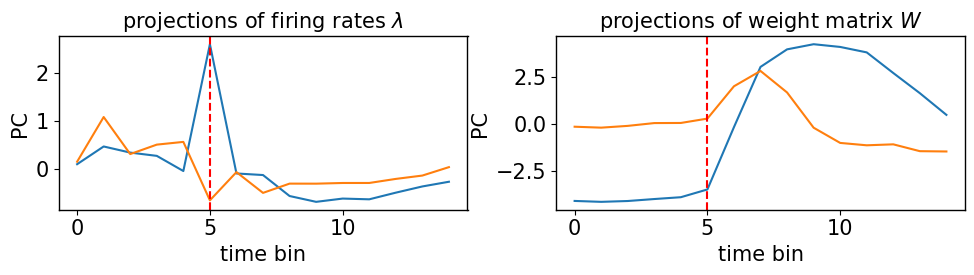

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 3))
pca = PCA(n_components=2)
pca.fit(firing_rates.mean(0).T)
fr_proj = pca.transform(firing_rates.mean(0).T)
ax1.plot(fr_proj)
ax1.axvline(x=5, c="r", linestyle="--")
ax1.set_xlabel("time bin")
ax1.set_ylabel("PC")
ax1.set_title(r"projections of firing rates $\lambda$")

pca.fit(weight_matrix.mean(0).T)
w_proj = pca.transform(weight_matrix.mean(0).T)
ax2.plot(w_proj)
ax2.axvline(x=5, c="r", linestyle="--")
ax2.set_xlabel("time bin")
ax2.set_ylabel("PC")
ax2.set_title(r"projections of weight matrix $W$")

plt.tight_layout()

In [38]:
_, y_test, density_pred, metrics = generic_decoder(
    weight_matrix, choice.squeeze(), train, test, 
    behavior_type="discrete", verbose=True
)

accuracy: 0.850
auc: 0.845


In [39]:
_, y_test, ks_pred, metrics = generic_decoder(
    all_sorted_spike_count, choice.squeeze(), train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.833
auc: 0.828


In [40]:
_, _, _, _ = generic_decoder(
    good_sorted_spike_count, choice.squeeze(), train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.767
auc: 0.763


In [41]:
_, _, _, _ = generic_decoder(
    thresholded_spike_count, choice.squeeze(), train, test, behavior_type="discrete", verbose=True
)

accuracy: 0.733
auc: 0.726
